<a name='0'></a>
# Intro to NLP and Text Processing with Pytorch

## Contents

* [1. Intro to Natural Language Processing](#1)
* [2. Text Processing with Pytorch](#2)
   * [2.1 Traditional Text Encoding](#2-1)
   * [2.2 Text Encoding with Tokenizer](#2-2)
   * [2.3 Converting Texts into Sequence of Tokens](#2-3)
   * [2.4 Padding Texts Sequences](#2-4)


* [3. Using TextVectorization](#3)

<a name='1'></a>
## 1. Intro to Natural Language Processing

We are surrounded by intelligent machines that can not only see the world, but also can understand and talk with us.

That is not exagerating. At regular basis, some of us interact with virtual assistants such as Siri, Amazon Alexa, and Google Assistant. And there are thousands of chatbots that we interact with on many software applications and websites.

NLP or Natural Language Processing is an interdisciplinary field. It is a branch of computer science, machine learning, and [computational linguistic](https://en.wikipedia.org/wiki/Computational_linguistics) that is concerned with giving the computers the ability to understand texts and human languages.

### Common tasks involved in NLP

Below are some of the common tasks that can be done with NLP.

* Text classification
* Sentiment analysis
* Text generation
* Machine translation
* Speech recognition
* Text to speech conversion
* Optical character recognition

#### Example Applications of NLP

* Spam detection
* Question answering
* Language to language translation (Machine translation)
* Grammatical error correction (like Grammarly)

One of the classical NLP tool is [NLTK](https://www.nltk.org). Natural Language Toolkit or NLTK provides different functionalities for working with texts and it is commonly used.

In this lab and later lab, we won't use NLTK. We will use Keras and PyTorch texts functions.

### Intro to Natural Language Processing (NLP) in PyTorch

In this section, we load a dataset, perform text preprocessing, and visualize the distribution of document lengths to understand the dataset.

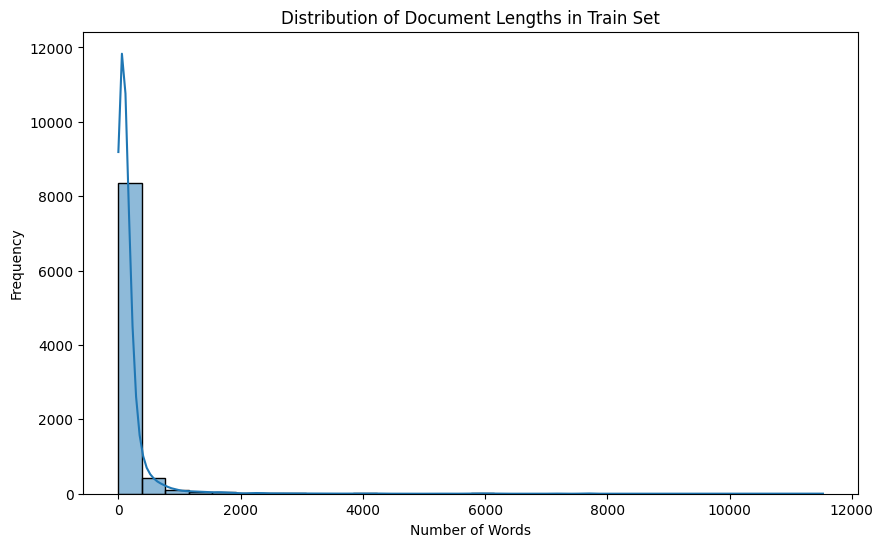

In [ ]:
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from sklearn.decomposition import PCA

# 1. Load and preprocess the 20 Newsgroups dataset
newsgroups_data = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
texts, labels = newsgroups_data.data, newsgroups_data.target

# Preprocess text: lowercase and remove non-alphabet characters
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    return text

texts = [preprocess_text(text) for text in texts]
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Visualization of document lengths
doc_lengths = [len(text.split()) for text in train_texts]
plt.figure(figsize=(10, 6))
sns.histplot(doc_lengths, bins=30, kde=True)
plt.title("Distribution of Document Lengths in Train Set")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

**Explanation:**

* We load the 20 Newsgroups dataset, a collection of newsgroup documents.
* We then preprocess each document by converting it to lowercase and removing non-alphabet characters.
* After splitting the dataset, we visualize the length of each document in words. This distribution helps us set padding limits for later tokenization.

<a name='2'></a>
## 2. Intro to Text Processing with PyTorch


<a name='2-1'></a>

### 2.1 Text encodings

Most machine learning models (including deep learning ones) can not handle text data. They have to be converted into numerics. In essence, that's what text encoding means: it's converting the text into numerics representation.

There are 4 main texts encoding techniques which are:
* Character encoding
* Words based encoding
* One hot encoding
* Word embeddings

Let's talk about these techniques in details.

#### Character Based Encoding

In this type of encoding technique, each character in a word is represented by unique number.

One of the traditional character encoding technique is ASCII(American Standard Code Information Interchange). With ASCII, we can nearly convert any character to numeric, and it's pretty standard, but one of the disadvantages is that the antigrams (words with same letters in different order) can have the same encodings, and that can hurt the machine learrning model.

Example of antigrams include `United` and `Unitied`, `Silent` and `Listen`.

Character encoding is not widely used and it's less efficient compared to other later techniques.

The image below shows character encoding done on antigrams.


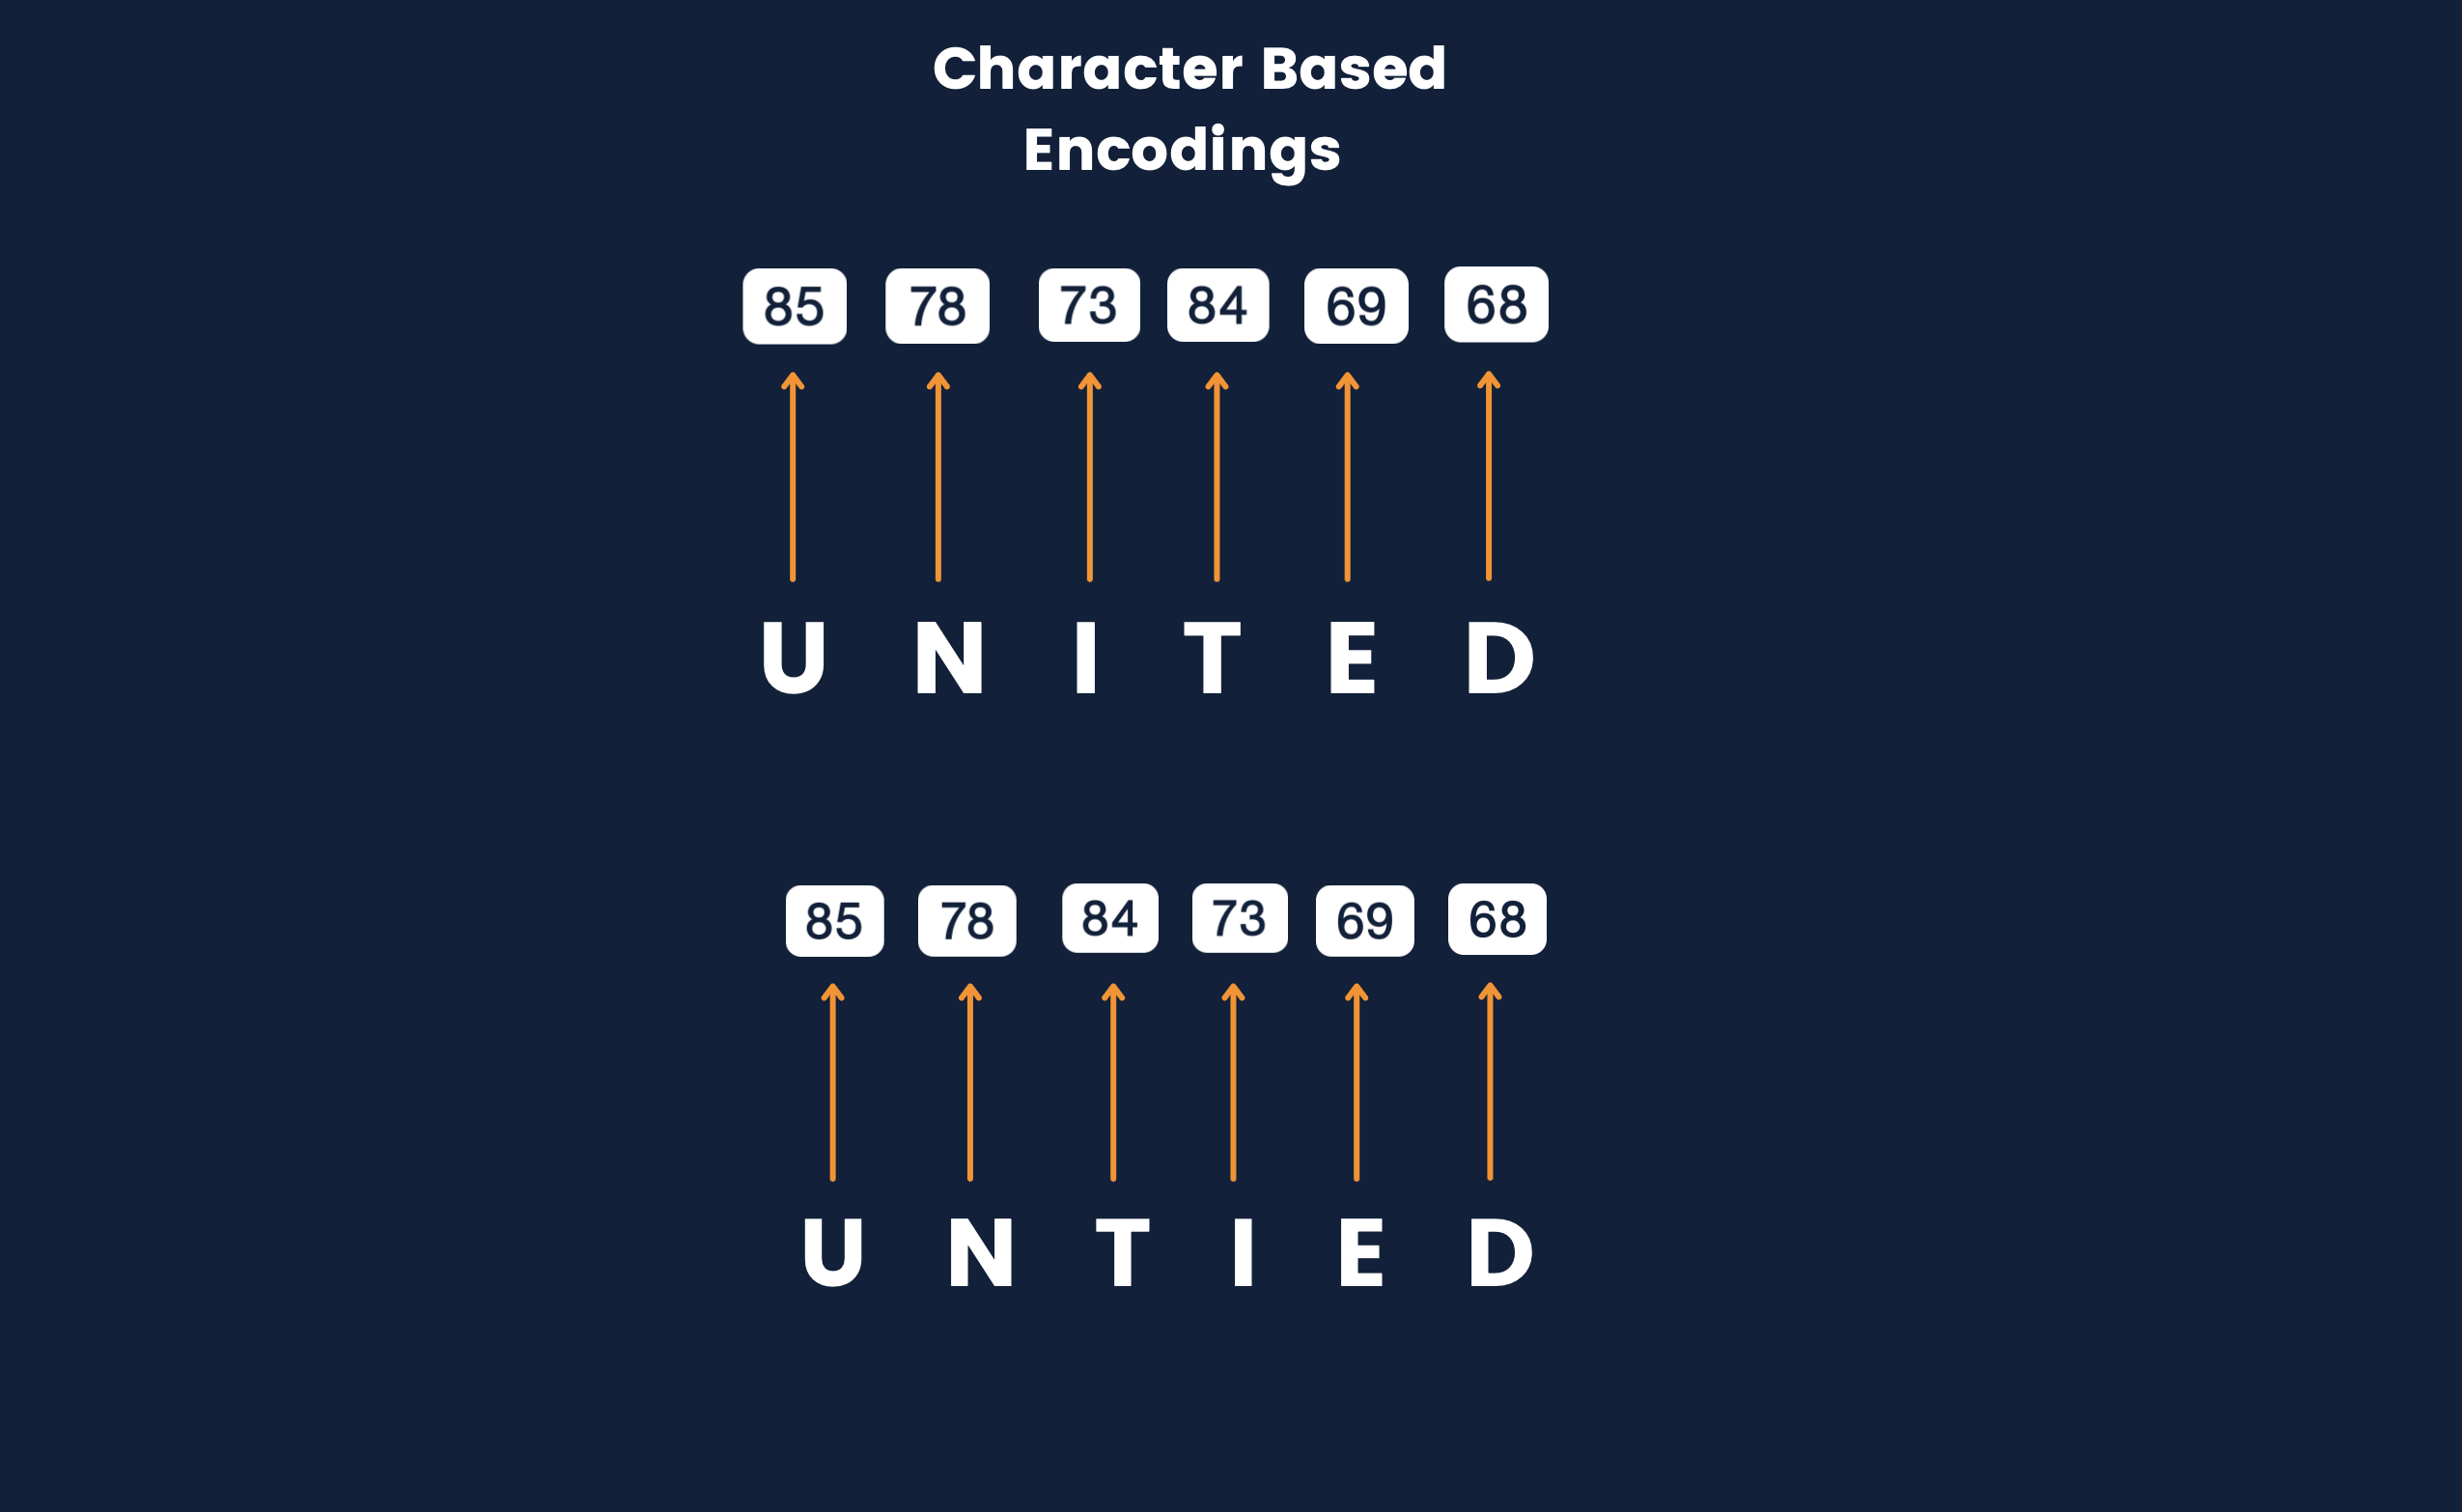

#### Words Based Encoding

In word based encoding, instead of taking a single character in a word, we represent all the individual words with numbers.

In most cases, words encoding works well than character encodings.

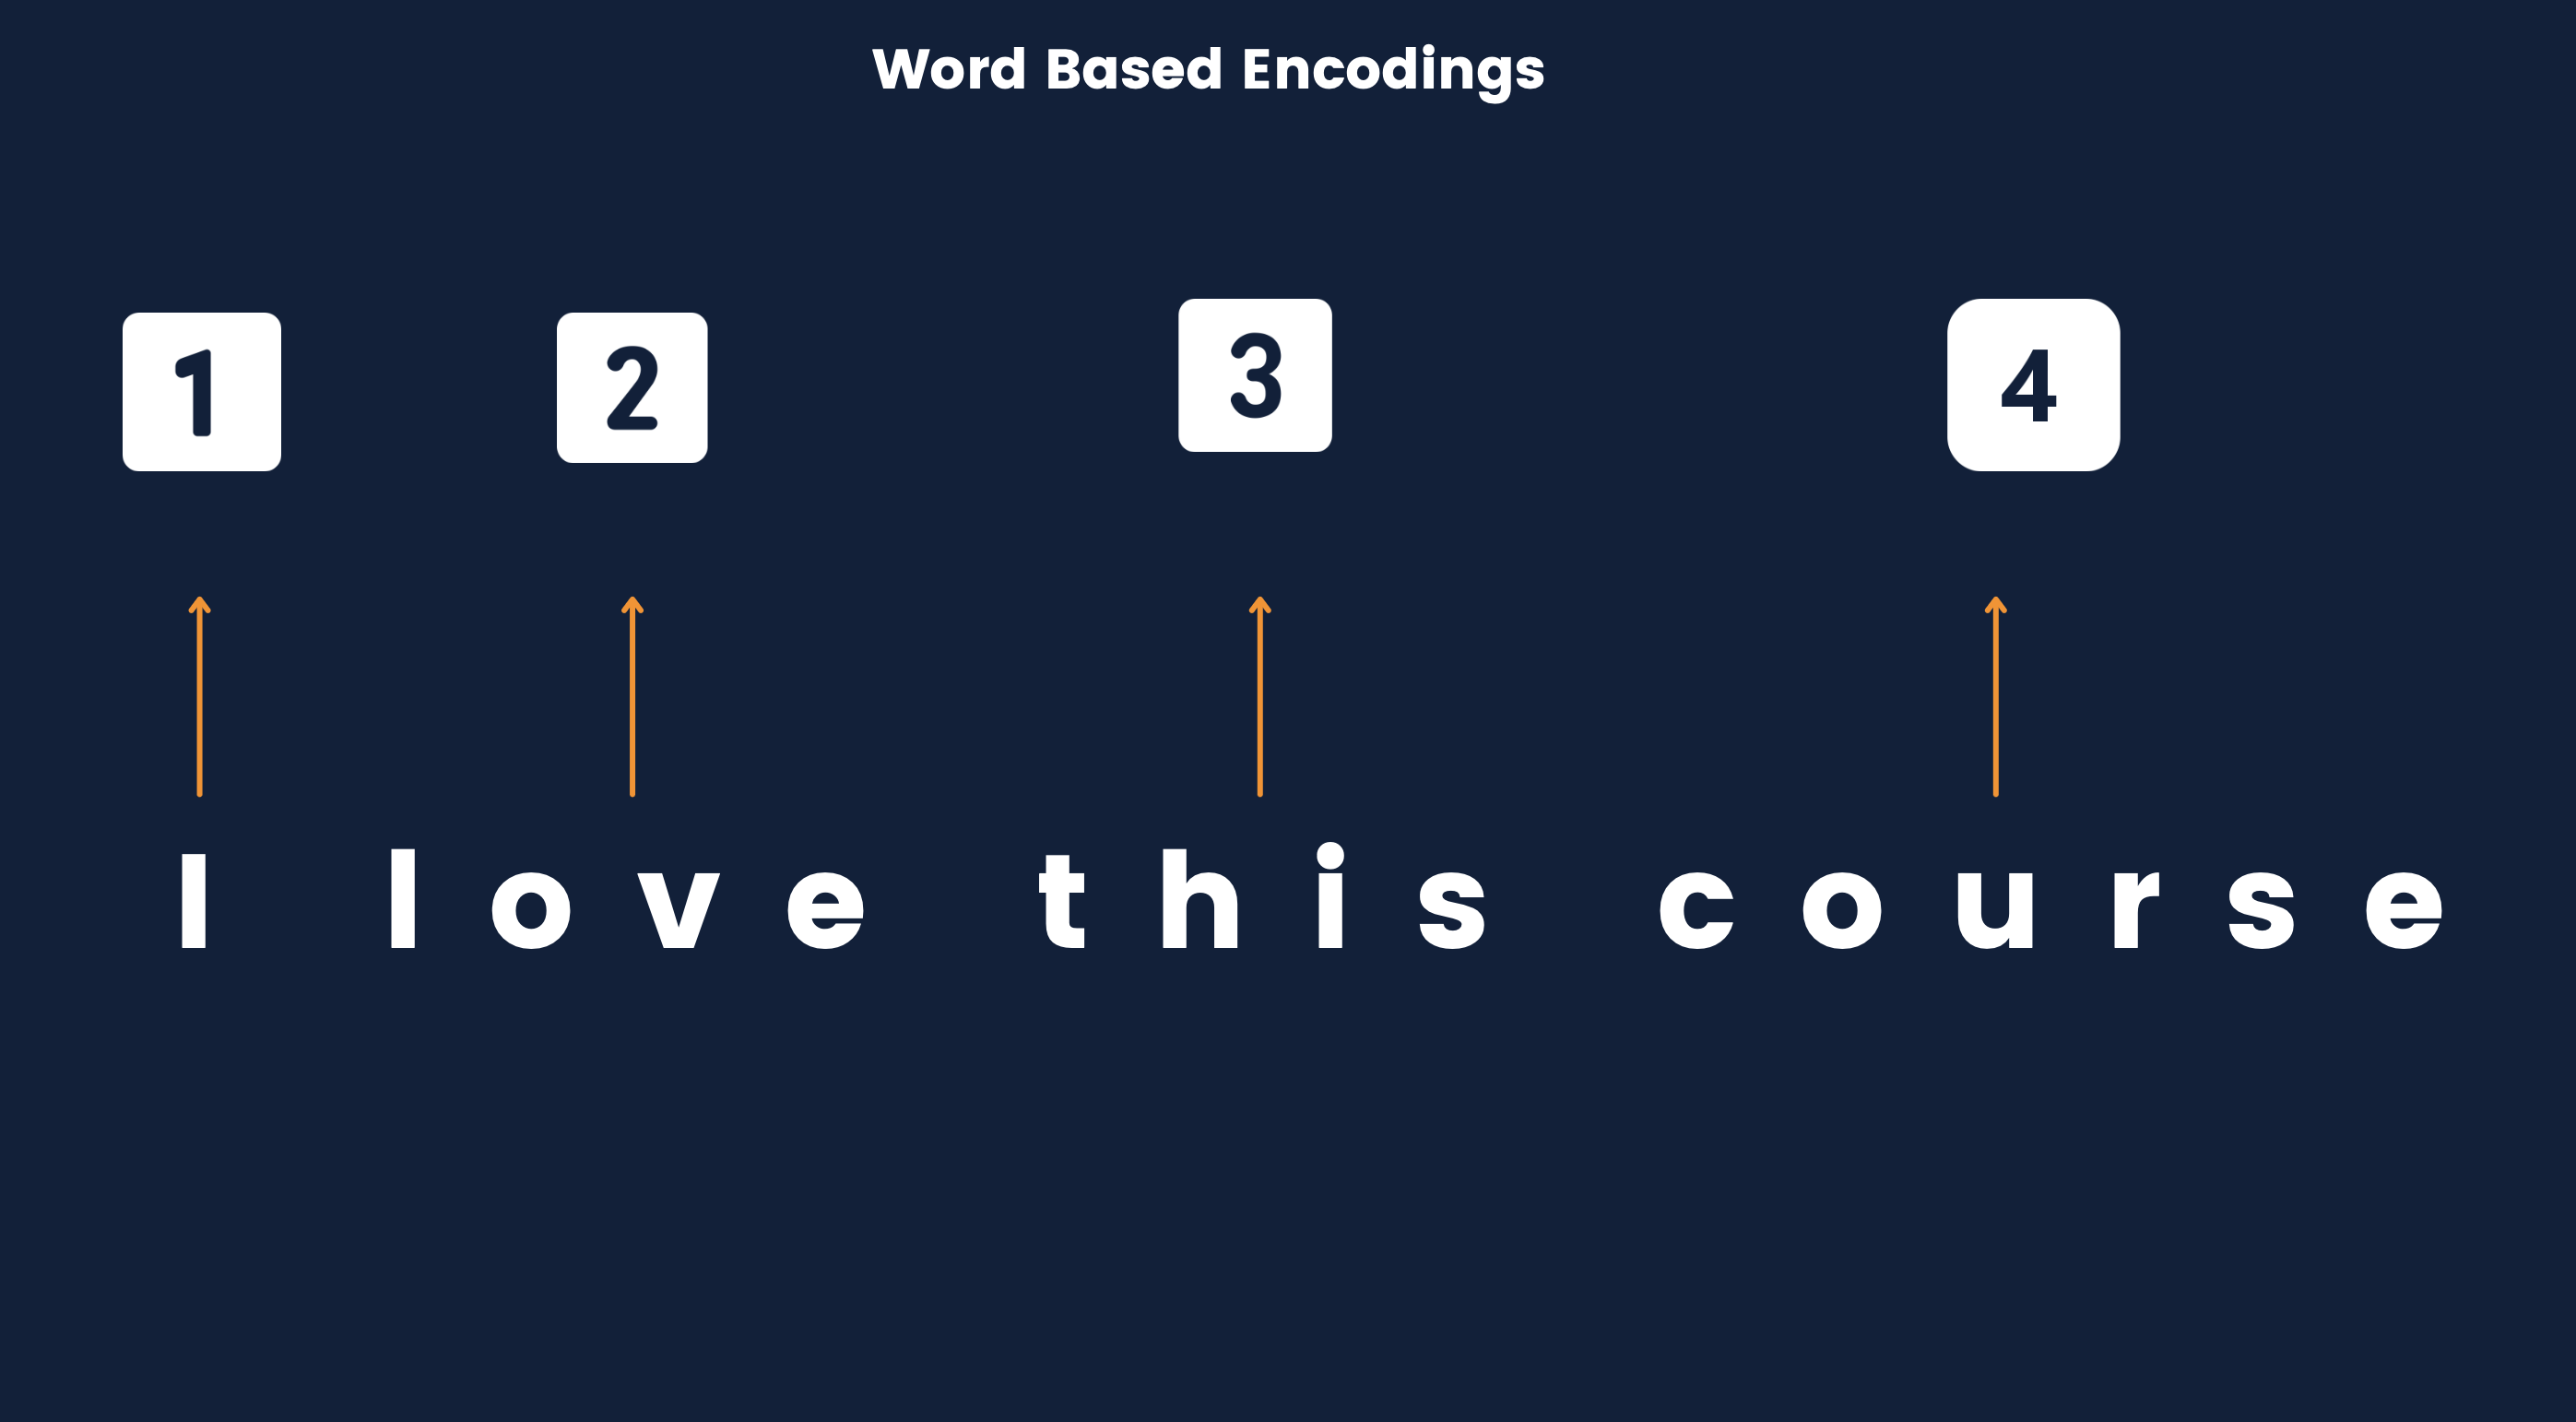

#### One Hot Encoding

One hot encoding is another encoding technique that is most known for [encoding categorical features](https://jeande.medium.com/your-onestop-guide-on-handling-categorical-features-5988caaef78a). Although it's not an effective, it can also be used for texts encoding, and the idea is to convert each words in a sentence into one hot vector, where that word will be `1(hot)` and all other words be `0(cold)` in such particular vector.

Take for instance the sentence `I love this course`. We can take words in such sentence [I, love, this, course] and then create a zero vector with length of 4, and then have 1 on the index that corresponds to the every word as it is shown below.

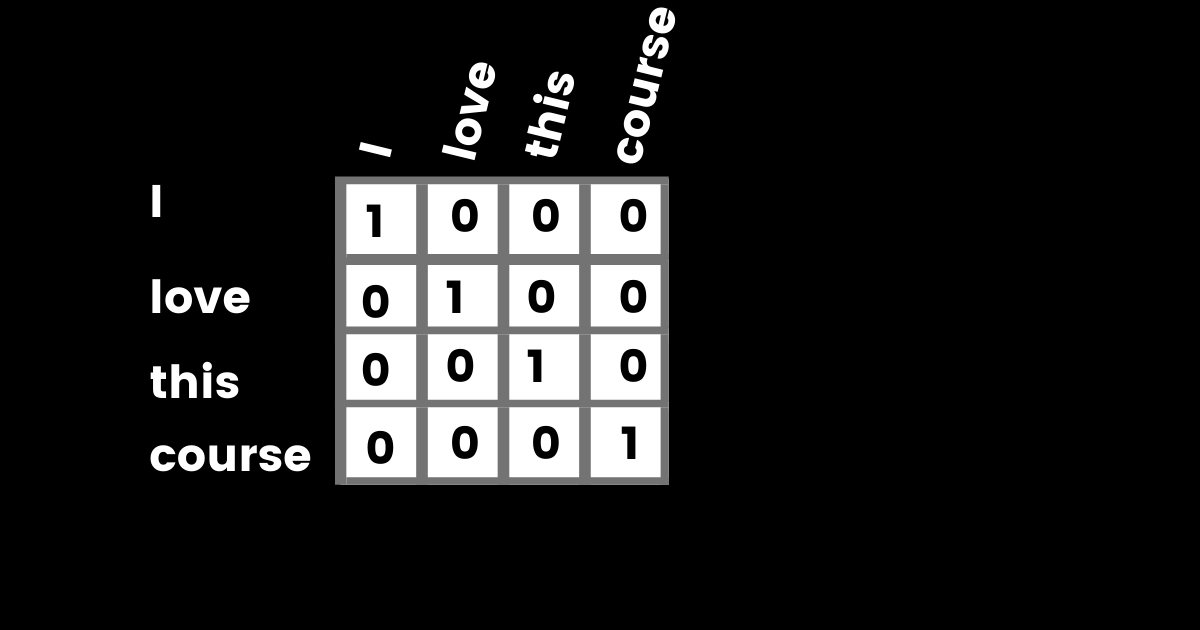

One hot encoding is not a better way to represent texts because most indices are zero and it becomes even harder when you have many words. It will take a lot of space in memory.

By far, in all encoding techniques we saw (character encoding, word encoding, and one hoting words), words encoding is a good way to represent texts. But there is a more better way that is called word embeddings.

Words embeddings are another way to represent texts where each word is converted into a feature vector, and vectors of the words that have the same semantic meaning will have the same direction in a high dimensional space. We will learn more about embeddings in the next notebook, but if you want you can play with them [here](http://projector.tensorflow.org).

### 2.1 Traditional Text Encoding

We use CountVectorizer to represent text as bag-of-words (BoW).

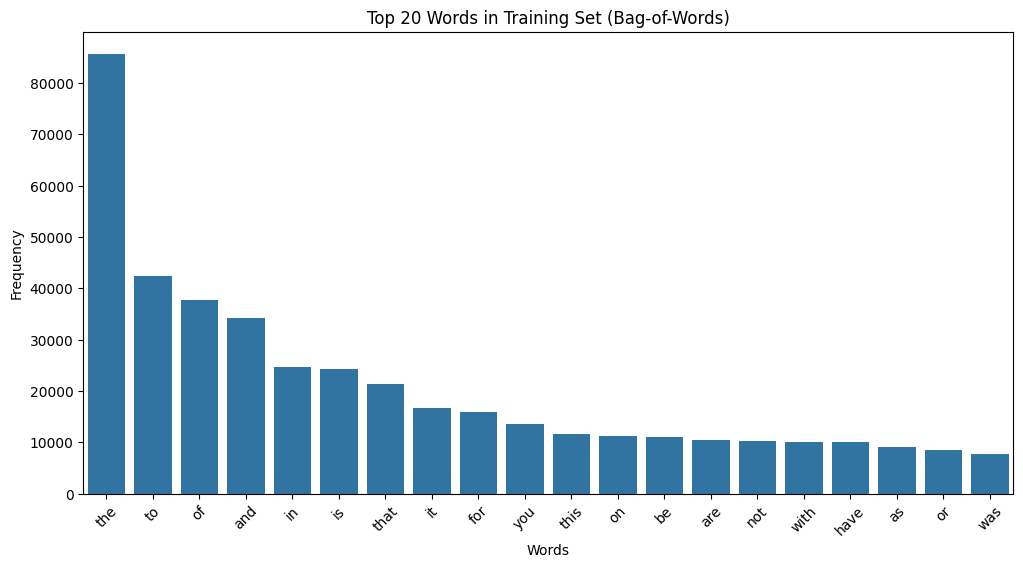

In [ ]:

vectorizer = CountVectorizer(max_features=1000)
train_texts_vectorized = vectorizer.fit_transform(train_texts).toarray()
val_texts_vectorized = vectorizer.transform(val_texts).toarray()

# Visualize top 20 words in the training set
word_counts = np.array(train_texts_vectorized).sum(axis=0)
top_indices = word_counts.argsort()[-20:][::-1]
top_words = np.array(vectorizer.get_feature_names_out())[top_indices]
top_counts = word_counts[top_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_words, y=top_counts)
plt.title("Top 20 Words in Training Set (Bag-of-Words)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()



**Explanation:**

* CountVectorizer is used to convert each document into a BoW vector, capturing word frequencies.
* We visualize the top 20 words to understand the vocabulary of our dataset and its most common terms.

<a name='2-2'></a>

### 2.2 Text Encoding with Tokenizer

Using a tokenizer (Hugging Face’s ``AutoTokenizer``), we can transform text data into token IDs.

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


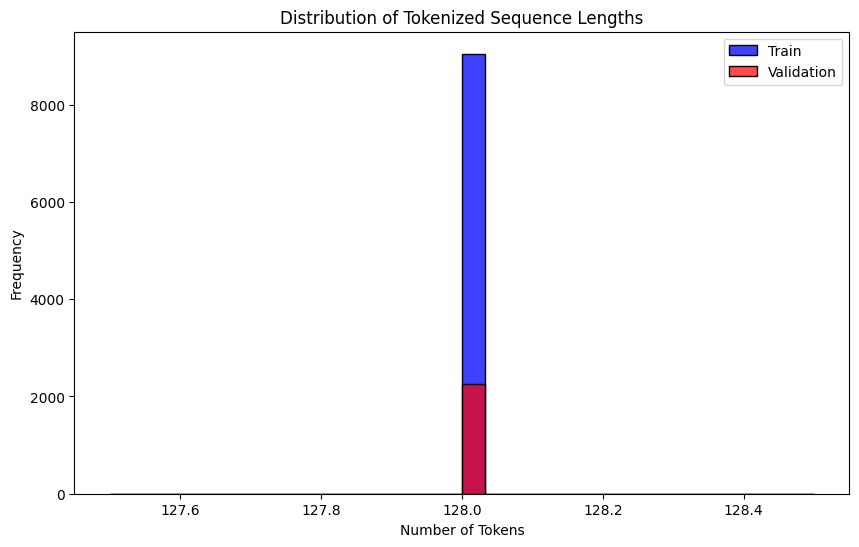

In [ ]:
# 2.2 Text Encoding with Tokenizer (using Hugging Face AutoTokenizer)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Visualize tokenized sequence lengths
train_lengths = [len(enc) for enc in train_encodings['input_ids']]
val_lengths = [len(enc) for enc in val_encodings['input_ids']]

plt.figure(figsize=(10, 6))
sns.histplot(train_lengths, bins=30, color="blue", label="Train")
sns.histplot(val_lengths, bins=30, color="red", label="Validation", alpha=0.7)
plt.title("Distribution of Tokenized Sequence Lengths")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.show()


**Explanation:**

* AutoTokenizer from Hugging Face’s library tokenizes texts, applying truncation and padding to create consistent token lengths.
* We plot token lengths to confirm if padding length (128) fits most sequences.

### 2.3 Converting Texts into Sequence of Tokens

Token IDs are used to represent each word in the vocabulary. This example shows token IDs for a sample sentence.

In [ ]:

# 2.3 Convert Texts into Sequence of Tokens
text_example = "Natural language processing with PyTorch."
tokens = tokenizer.encode(text_example, add_special_tokens=True)
print(f"Token IDs for '{text_example}': {tokens}")



Token IDs for 'Natural language processing with PyTorch.': [101, 3019, 2653, 6364, 2007, 1052, 22123, 2953, 2818, 1012, 102]


**Explanation:**

* encode method from ``AutoTokenizer`` converts text to token IDs.
* Printing the token IDs helps us understand how specific words are encoded.

### 2.4 Padding Text Sequences

PyTorch uses ``pad_sequence`` to standardize sequence lengths by padding shorter sequences.

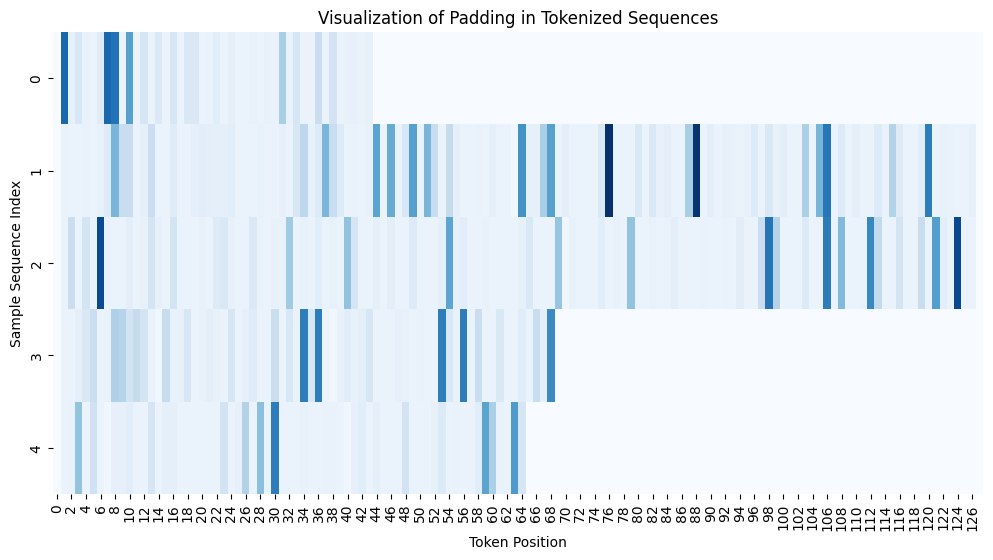

In [ ]:
# 2.4 Padding Text Sequences
train_token_ids = [torch.tensor(t) for t in train_encodings['input_ids']]
val_token_ids = [torch.tensor(t) for t in val_encodings['input_ids']]

train_padded = pad_sequence(train_token_ids, batch_first=True, padding_value=0)
val_padded = pad_sequence(val_token_ids, batch_first=True, padding_value=0)

# Visualize padding
sample_padded = train_padded[:5].numpy()
plt.figure(figsize=(12, 6))
sns.heatmap(sample_padded, cmap="Blues", cbar=False)
plt.title("Visualization of Padding in Tokenized Sequences")
plt.xlabel("Token Position")
plt.ylabel("Sample Sequence Index")
plt.show()

**Explanation:**

* ``pad_sequence`` pads sequences to the maximum length in each batch.
* We visualize padding as a heatmap, showing 0s where padding is applied.

# 3. Using TextVectorization (PyTorch Embeddings)

In this section, we create embeddings using PyTorch’s ``nn.Embedding``. The embedding layer learns word representations in lower-dimensional space.

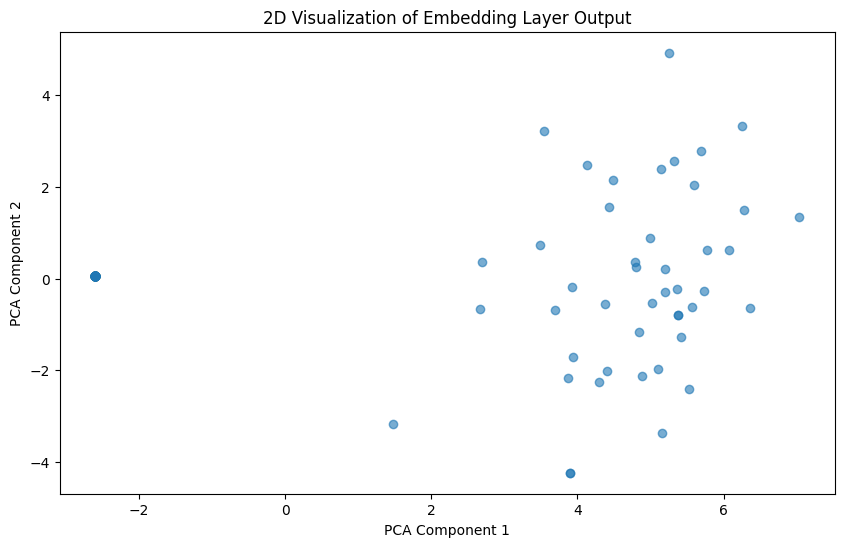

In [ ]:
# 3. Using TextVectorization (PyTorch Embeddings)
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

train_dataset = TextDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = TextDataset(val_texts, val_labels, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Embedding layer using vocabulary size from tokenizer
vocab_size = tokenizer.vocab_size  # Set num_embeddings to tokenizer's vocab size
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=50)

# Generate embeddings for a sample input
sample_input_ids = train_dataset[0]['input_ids']  # Example input IDs
with torch.no_grad():
    sample_embeddings = embedding_layer(sample_input_ids)

# Reduce dimensionality of embeddings with PCA for visualization
sample_embeddings_np = sample_embeddings.numpy()
pca = PCA(n_components=3)
reduced_embeddings = pca.fit_transform(sample_embeddings_np)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.6)
plt.title("2D Visualization of Embedding Layer Output")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


In [ ]:
# Import required libraries
from sklearn.decomposition import PCA
import plotly.graph_objects as go

# Step 1: Reduce dimensionality of embeddings to 3D with PCA
# Generate embeddings for a sample input
sample_input_ids = train_dataset[0]['input_ids']  # Example input IDs

# Check embeddings for the entire vocabulary (optional: to visualize more than a single sentence)
with torch.no_grad():
    sample_embeddings = embedding_layer(sample_input_ids)

# Convert to numpy and reduce dimensions
sample_embeddings_np = sample_embeddings.numpy()
pca = PCA(n_components=3)
reduced_embeddings_3d = pca.fit_transform(sample_embeddings_np)

# Step 2: Create a 3D interactive plot using Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_embeddings_3d[:, 0],
    y=reduced_embeddings_3d[:, 1],
    z=reduced_embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=reduced_embeddings_3d[:, 2],  # Color by Z-axis value for variation
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Step 3: Add plot details
fig.update_layout(
    title="3D Interactive Visualization of Embedding Layer Output",
    scene=dict(
        xaxis_title="PCA Component 1",
        yaxis_title="PCA Component 2",
        zaxis_title="PCA Component 3"
    )
)

# Show the interactive plot
fig.show()


In [ ]:
import torch
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import numpy as np

# Define a set of target words to visualize and find nearest neighbors
target_words = ["language", "processing", "learning", "network", "data", "science"]

# Step 1: Get token IDs and embeddings for each target word
target_word_ids = [tokenizer.encode(word, add_special_tokens=False)[0] for word in target_words]
with torch.no_grad():
    target_embeddings = embedding_layer(torch.tensor(target_word_ids))

# Step 2: Find embeddings for all words in the vocabulary
vocab_size = embedding_layer.num_embeddings
with torch.no_grad():
    all_embeddings = embedding_layer(torch.arange(vocab_size))

# Step 3: Use PCA to reduce the embeddings to 3D space
pca = PCA(n_components=3)
all_embeddings_reduced = pca.fit_transform(all_embeddings.numpy())
target_embeddings_reduced = pca.transform(target_embeddings.numpy())

# Step 4: Find nearest neighbors for each target word
def find_nearest_neighbors(embedding, all_embeddings, k=5):
    distances = np.linalg.norm(all_embeddings - embedding, axis=1)
    nearest_indices = distances.argsort()[1:k+1]  # Skip the first one (the word itself)
    return nearest_indices

# Prepare data for plotting: store coordinates and labels
x_coords, y_coords, z_coords, labels = [], [], [], []
for idx, word_embedding in enumerate(target_embeddings_reduced):
    # Add target word coordinates
    x_coords.append(word_embedding[0])
    y_coords.append(word_embedding[1])
    z_coords.append(word_embedding[2])
    labels.append(target_words[idx])

    # Find nearest neighbors and add their coordinates
    neighbors_idx = find_nearest_neighbors(word_embedding, all_embeddings_reduced, k=5)
    for neighbor_idx in neighbors_idx:
        x_coords.append(all_embeddings_reduced[neighbor_idx, 0])
        y_coords.append(all_embeddings_reduced[neighbor_idx, 1])
        z_coords.append(all_embeddings_reduced[neighbor_idx, 2])
        labels.append(tokenizer.decode([neighbor_idx]))  # Decode token ID to word

# Step 5: Create 3D interactive plot with Plotly
fig = go.Figure()

# Add points with text labels for target words and neighbors
fig.add_trace(go.Scatter3d(
    x=x_coords,
    y=y_coords,
    z=z_coords,
    text=labels,
    mode='markers+text',
    marker=dict(size=5, color='blue', opacity=0.7),
    textposition="top center"
))

# Customize layout
fig.update_layout(
    title="3D PCA of Word Embeddings with Nearest Neighbors",
    scene=dict(
        xaxis_title="PCA Component 1",
        yaxis_title="PCA Component 2",
        zaxis_title="PCA Component 3"
    )
)

# Show plot
fig.show()


## Summary

This is the end of the lab. NLP is a machine learning field that deals with texts.

Both NLP and Computer Vision are two of the most exciting fields in AI and machine learning and being able to know them can help you build cross applications. For example, given an image of a kid playing basketball, you can use computer vision techniques to recognize image, and generate a caption with NLP techniques. That's awesome, right!?

So, in the lab we also learned how to represent texts as numbers because the input data to most machine learning models must be vectors or array of numbers. We saw how to tokenize words, convert tokens into sequences, and padd the sequences. Also we saw how to convert texts into vectors or numbers with TextVectorization layer.

In the next lab, we will learn about another useful texts representation techniques called word embeddings.